# Import the libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Sequential
from pathlib import Path
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

import warnings
warnings.filterwarnings('ignore')

# import the dataset

In [ ]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/archive.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

Mounted at /content/drive/


In [ ]:
!unzip '/content/drive/MyDrive/archive.zip' -d '/content/images'

Streaming output truncated to the last 5000 lines.
  inflating: /content/images/images/validation/fear/8797.jpg  
  inflating: /content/images/images/validation/fear/8818.jpg  
  inflating: /content/images/images/validation/fear/886.jpg  
  inflating: /content/images/images/validation/fear/9037.jpg  
  inflating: /content/images/images/validation/fear/9040.jpg  
  inflating: /content/images/images/validation/fear/9101.jpg  
  inflating: /content/images/images/validation/fear/911.jpg  
  inflating: /content/images/images/validation/fear/9179.jpg  
  inflating: /content/images/images/validation/fear/9205.jpg  
  inflating: /content/images/images/validation/fear/9232.jpg  
  inflating: /content/images/images/validation/fear/9251.jpg  
  inflating: /content/images/images/validation/fear/9261.jpg  
  inflating: /content/images/images/validation/fear/9281.jpg  
  inflating: /content/images/images/validation/fear/9302.jpg  
  inflating: /content/images/images/validation/fear/9333.jpg  
  infl

In [ ]:
train_dir=Path(r"/content/images/images/images/train")
test_dir=Path(r"/content/images/images/images/validation")

In [ ]:
batch_size = 64
img_height = 56
img_width = 56

In [ ]:
datagen_train  = ImageDataGenerator()
datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(train_dir,
                                              target_size = (img_height,img_width),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(test_dir,
                                              target_size = (img_height, img_width),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

Found 28806 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [ ]:
train_pic = tf.keras.utils.image_dataset_from_directory(r"/content/images/images/images/train")
test_pic = tf.keras.utils.image_dataset_from_directory(r"/content/images/images/images/validation")

Found 28806 files belonging to 7 classes.
Found 7066 files belonging to 7 classes.


In [ ]:
class_names = train_pic.class_names
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
for image_batch, labels_batch in train_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 56, 56, 1)
(64, 7)


# Building CNN model

In [ ]:
num_classes = len(class_names)
model = Sequential()

# 1 Convolution
model.add(Conv2D(32,(5,5), padding='same', input_shape=(img_height, img_width, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 2 Convolution layer
model.add(Conv2D(64,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# 3 Convolution layer
model.add(Conv2D(128,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 4 Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

# Fully connected layer 1 layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Fully connected layer 1 layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 56, 56, 32)        832       
                                                                 
 batch_normalization_6 (Batc  (None, 56, 56, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 56, 56, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 28, 28, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)       

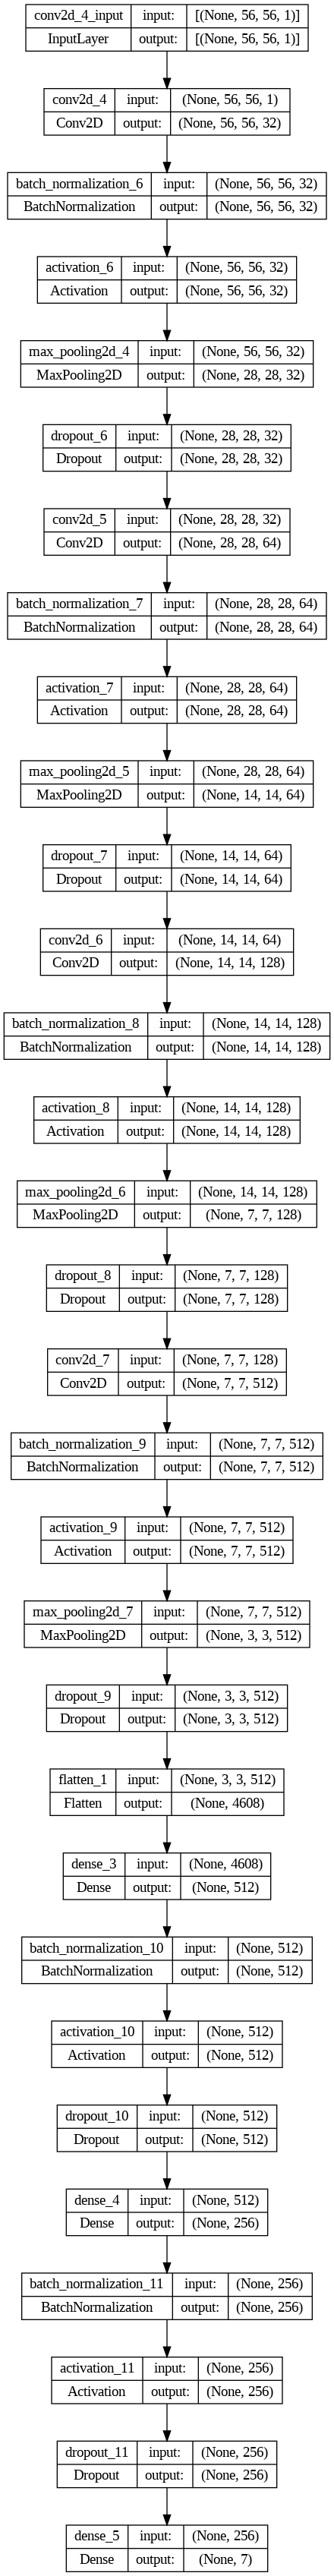

In [ ]:
best = tf.keras.models.load_model('bestmodel.hdf5')

from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [ ]:
checkpoint = ModelCheckpoint(filepath="bestmodel.hdf5", monitor='val_loss', 
                             save_best_only=True, save_weights_only=False, verbose=3)

earlystopper = EarlyStopping(monitor='val_loss', patience=10)

callbackslist = [checkpoint, earlystopper]

num_epochs = 100

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit_generator(train_set, epochs=num_epochs, validation_data=test_set, callbacks=callbackslist)

# graphs

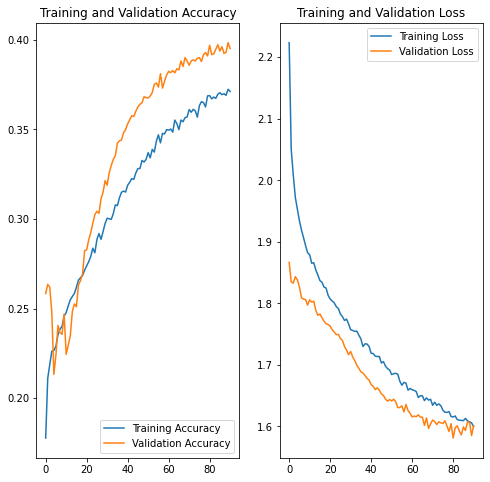

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
best = tf.keras.models.load_model('bestmodel.hdf5')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = best.predict(test_set)

predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for x, y in test_set], axis=0)

confusion_mtx = confusion_matrix(predicted_categories, true_categories)

111/111 [==============================] - 2s 18ms/step


In [ ]:
plt.figure(figsize = (25,25))
sns.heatmap(confusion_mtx,cmap= "Reds", linecolor = 'gray' , linewidth = 0.01 , annot = True, fmt='.2f' , xticklabels = class_names , yticklabels = class_names)
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()

# Testing

In [ ]:
best = tf.keras.models.load_model('bestmodel.hdf5')
best.evaluate(test_set)

111/111 [==============================] - 2s 20ms/step - loss: 1.5809 - accuracy: 0.3970


[1.5809195041656494, 0.3969714045524597]

In [ ]:
path = r"/content/images/images/validation/sad/1003.jpg"

from PIL import Image
im = Image.open(path)
plt.imshow(im)
plt.show()


img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width), color_mode = "grayscale"
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = best.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))

--------